# Chat bot development ( Based on Sentiment using RNN )

## Developer: Yogesh Awdhut Gadade

#### Input dataset: Topical chat (Amazon Alexa AI) 

#### system configuration: 
- Program run on 16 GB RAM, 6 GB of GPU

#### Which package needs to be installed
- tensorflow

In [ ]:
from pandas import DataFrame, read_json, read_csv
import gc          # Garbage collector
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

#### Versions of python and packages used in this notebook:
1. Python: 3
2. Pandas: 1.0.5 (!pip show pandas)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
strInputDirPath=".//input//train.json" # Set current input directory path

strInputDirPath="/content/drive/MyDrive/Stevens/Deep Learning/input/"

In [ ]:
# On local machine:
#pdChatData=read_csv("ChatExpanded.csv")
# on google drive
pdChatData=read_csv(strInputDirPath+"sampling.csv")

In [ ]:
pdChatData.columns

Index(['conversation_id', 'config', 'agent', 'message', 'agent_1Overall',
       'agent_2Overall', 'sentiment', 'turn_rating', 'knowledge_source',
       'article_url', 'LemmatizedText'],
      dtype='object')

In [ ]:
pdChatData.head(2)

,conversation_id,config,agent,message,agent_1Overall,agent_2Overall,sentiment,turn_rating,knowledge_source,article_url,LemmatizedText
0,t_86627de2-fe27-42f1-9250-85054ba5353b,B,agent_1,Have you seen Ethiopias version of Top Chef?,Good,Good,Curious to dive deeper,Good,FS2,https://www.washingtonpost.com/news/inspired-l...,see ethiopia version top chef
1,t_f3a6d5fb-7f18-41e9-9ab1-5599d265812f,C,agent_2,It has been a pleasure talking to you too. En...,Good,Passable,Happy,Good,Personal Knowledge,https://www.washingtonpost.com/local/human-rem...,pleasur talk enjoy rap music internet


In [ ]:
print(f"Total number of chats (conversations) : {len(pdChatData)}")
print(f"Total number of Agents                : {len(pdChatData.agent.unique()), list(pdChatData.agent.unique())}")
print(f"Total number of sentiment             : {len(pdChatData.sentiment.unique()), list(pdChatData.sentiment.unique())}")
print(f"Total number of knowledge_source      : {len(pdChatData.knowledge_source.unique()), list(pdChatData.knowledge_source.unique())}")

Total number of chats (conversations) : 25633
Total number of Agents                : (2, ['agent_1', 'agent_2'])
Total number of sentiment             : (8, ['Curious to dive deeper', 'Happy', 'Surprised', 'Neutral', 'Sad', 'Fearful', 'Disgusted', 'Angry'])
Total number of knowledge_source      : (8, ['FS2', 'Personal Knowledge', 'FS3', 'FS1', 'AS3', 'AS1', 'AS4', 'AS2'])


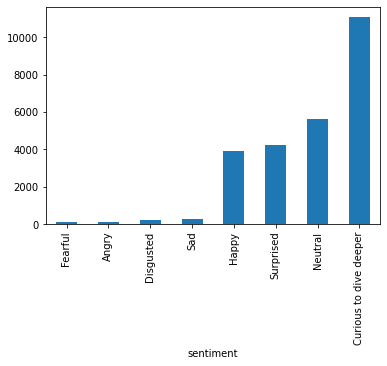

In [ ]:
pdChatData.groupby('sentiment').count().sort_values('conversation_id')['conversation_id'].plot(kind='bar')

### OBSERVATION:
- In the subsample we got from the above step giving us the same distribution as the original dataset has. Hence going to use this for further training and tesing. 

In [ ]:
# if not present download following
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
print('Total number of rows we have: ', len(pdChatData))

Total number of rows we have:  25633


In [ ]:
#5. encoding the outputs: target variables are also encoded to decimal values. 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
pdChatData['Labels']=le.fit_transform(pdChatData.sentiment)

# Chatbot based on sentiment using RNN(LSTM)

In [ ]:
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

tokenizer=''
def preprocess_data_for_rnn(data):
    global tokenizer
    #1. Removing punctuations
    #data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
    #data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))

    #2. Tokenize the data
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(data['inputs'])
    #Tensorflow’s tokenizer assigns a unique token to each distinct word. 


    #3. Transform/Convert text to sequence
    train = tokenizer.texts_to_sequences(data['inputs'])

    #4. Apply padding: padding is done to get all the data to the same length so as to send it to an RNN layer. 
    x_train = pad_sequences(train)

    #5. encoding the outputs: target variables are also encoded to decimal values. 
    le = LabelEncoder()
    y_train = le.fit_transform(data['tags'])
    
    vocabulary, input_shape, output_length=get_model_input_values(x_train, tokenizer, le)
    
    return x_train, y_train, vocabulary, input_shape, output_length

def get_model_input_values(x_train, tokenizer, le):
    #input length
    input_shape = x_train.shape[1]
    print("Input shape: ", input_shape)
    #define vocabulary
    vocabulary = len(tokenizer.word_index)
    print("number of unique words in vocabulary: ",vocabulary)
    #output length
    output_length = le.classes_.shape[0]
    print("output length: ",output_length)
    
    return vocabulary, input_shape, output_length

In [ ]:
# Define Model: creating the model
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model

def get_rnn_model(input_shape, vocabulary):

    i = Input(shape=(input_shape,))
    x = Embedding(vocabulary+1,333)(i)
    x = LSTM(333,return_sequences=True)(x)
    x = Flatten()(x)
    x = Dense(output_length,activation="softmax")(x)
    model  = Model(i,x)
    #compiling the model
    model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])
    
    return model

In [ ]:
#data=pdChatData.copy()
data=pdChatData[['LemmatizedText', 'Labels']].astype(str).rename(columns={'LemmatizedText': 'inputs', 'Labels': 'tags'})
data.head()
print("Total Samples to train:", len(data))

Total Samples to train: 25633


In [ ]:
data.head(2)

,inputs,tags
0,see ethiopia version top chef,1
1,pleasur talk enjoy rap music internet,4


In [ ]:
#del(model)
gc.collect()

122

In [ ]:
%time x_train, y_train, vocabulary, input_shape, output_length=preprocess_data_for_rnn(data)
model=get_rnn_model(input_shape, vocabulary)

Input shape:  53
number of unique words in vocabulary:  10459
output length:  8
CPU times: user 898 ms, sys: 22.6 ms, total: 920 ms
Wall time: 912 ms


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 53)]              0         
                                                                 
 embedding (Embedding)       (None, 53, 333)           3483180   
                                                                 
 lstm (LSTM)                 (None, 53, 333)           888444    
                                                                 
 flatten (Flatten)           (None, 17649)             0         
                                                                 
 dense (Dense)               (None, 8)                 141200    
                                                                 
Total params: 4,512,824
Trainable params: 4,512,824
Non-trainable params: 0
_________________________________________________________________


In [20]:
#training the model
%time modelRNN = model.fit(x_train,y_train,epochs=20, batch_size=32)  

Epoch 1/20
802/802 [==============================] - 351s 437ms/step - loss: 1.3575 - accuracy: 0.4464
Epoch 2/20
802/802 [==============================] - 349s 435ms/step - loss: 1.1745 - accuracy: 0.5337
Epoch 3/20
802/802 [==============================] - 347s 432ms/step - loss: 0.9322 - accuracy: 0.6394
Epoch 4/20
802/802 [==============================] - 344s 430ms/step - loss: 0.6824 - accuracy: 0.7406
Epoch 5/20
802/802 [==============================] - 335s 418ms/step - loss: 0.5124 - accuracy: 0.8037
Epoch 6/20
802/802 [==============================] - 340s 424ms/step - loss: 0.4004 - accuracy: 0.8488
Epoch 7/20
802/802 [==============================] - 344s 429ms/step - loss: 0.3142 - accuracy: 0.8817
Epoch 8/20
802/802 [==============================] - 356s 444ms/step - loss: 0.2537 - accuracy: 0.9072
Epoch 9/20
802/802 [==============================] - 358s 446ms/step - loss: 0.2096 - accuracy: 0.9231
Epoch 10/20
802/802 [==============================] - 358s 446m

In [21]:
# save model
#modelRNN.('rnn_model_for_chat.h5')

In [22]:
# save model immediately here in another notebook try to develop chat response mechanism based on sentiment prediction

The Network consist of an embedding layer which is one of the most powerful things in the field of natural language processing. the outputs of the embedding layer is the input of the reccurent layer with lstm gate. then, the output is flattened and a regular dense layer is used with a softmax activation function.

In [23]:
pdChatData.sentiment.unique()

array(['Curious to dive deeper', 'Happy', 'Surprised', 'Neutral', 'Sad',
       'Fearful', 'Disgusted', 'Angry'], dtype=object)

# Response from chatbot - here use beam search technique

1. Input: These are exactly the messages that the user is going to be sending to the bot.
2. tags : tags are used to categorise the inputs and map them to a particular type of response
3. responses : once, we have mapped an input to an appropriate tag, we can select one of the response to give back to the user.


In [ ]:
# Creating responses dictionary. 
# Trained model will predict the sentiment. Responses will have chat listed for each sentiment one of which will be output
lstSentiments=list(pdChatData.sentiment.unique())
responses = {}
for strSentiment in lstSentiments:
    responses[strSentiment] = list(pdChatData[pdChatData.sentiment == strSentiment]['message'].unique())
    
    
#chatting
import random
import numpy as np
blFlag=True
while blFlag:
    texts_p = []
    prediction_input = input('You : ')
    if str(prediction_input) == "exit":
        blFlag=False
        break
    #removing punctuation and converting to lowercase
    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = ''.join(prediction_input)
    texts_p.append(prediction_input)
    #tokenizing and padding
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input],input_shape)
    #getting output from model
    output = model.predict(prediction_input)
    output = output.argmax()
    #finding the right tag and predicting
    response_tag = le.inverse_transform([output])[0]
    print(response_tag)
    
    
    print("Chatbot : ", random.choice(responses[response_tag]))
    
    



## Conclusion:
- Althoug model achieved more than 98% but the response technique will need further improvements in creating responses ( beam search )